## Prepare train_data and test_data

In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
X,y = datasets.load_breast_cancer(as_frame=True,return_X_y=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=335)
train_data = pd.concat([X_train,y_train],axis=1)
eval_data = pd.concat([X_test,y_test],axis=1)

# Use make_experiment to train model

In [3]:
from hypergbm import HyperGBM
from hypergbm.search_space import search_space_general
from hypernets.searchers.random_searcher import RandomSearcher
from hypernets.tabular.metrics import calc_score
import shap

In [4]:
from hypergbm import make_experiment
experiment = make_experiment(train_data.copy(),target='target',ensemble_size=0)
estimator = experiment.run()

ExperimentProcessWidget(initData='{"steps": [{"index": 0, "name": "data_clean", "type": "DataCleanStep", "stat…

Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations


# Use shap to analyse HyperModel
-- visit https://github.com/slundberg/shap for more datails

In [5]:
shap.initjs()
explainer = shap.KernelExplainer(estimator.predict_proba,X_train,keep_index=True)

Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [6]:
data_show = shap.sample(X_test,1)
shap_values = explainer.shap_values(data_show)
shap.force_plot(explainer.expected_value[0], shap_values[0], data_show)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

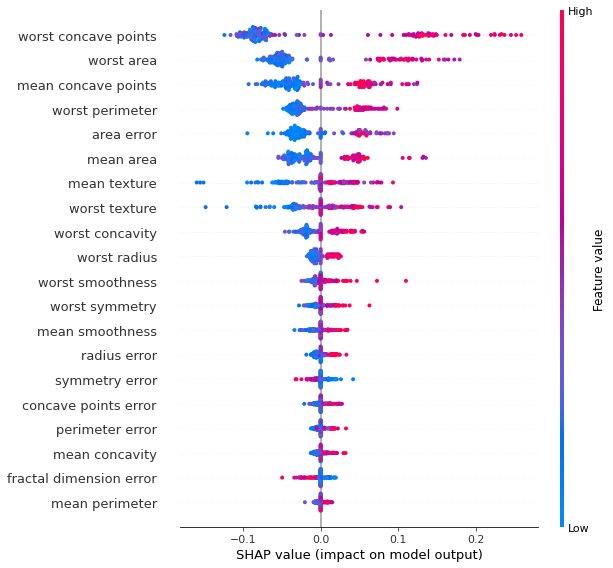

In [7]:
shap_values_full = explainer.shap_values(X_test)[0]
shap.summary_plot(shap_values_full, X_test)

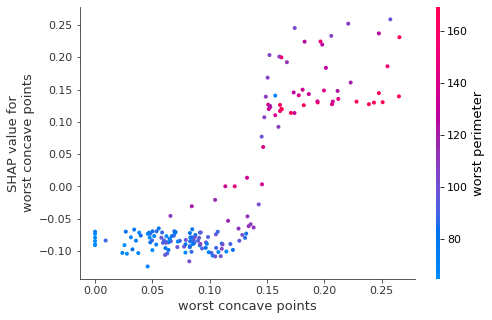

In [8]:
# shap.dependence_plot("worst concave points", shap_values_full, X_test)
shap.dependence_plot("worst concave points", shap_values_full, X_test,
                     interaction_index='worst perimeter')

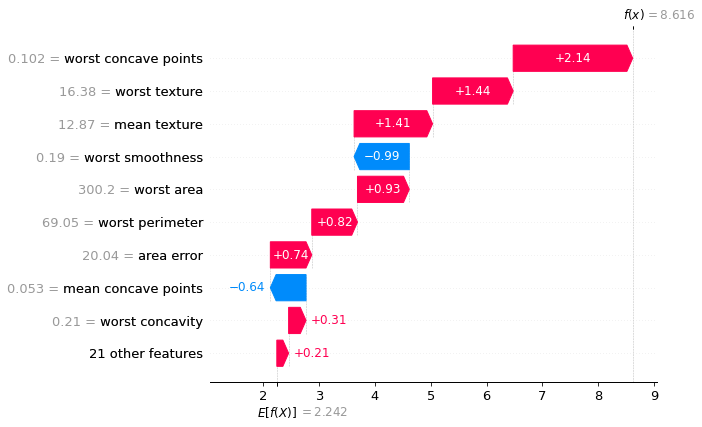

In [9]:
import lightgbm as lgb
model = lgb.LGBMClassifier().fit(X_train, y_train)
explainer = shap.Explainer(model)
shap_values = explainer(X_test)[0]
shap_values.base_values=shap_values.base_values[1]
shap_values.values=shap_values.values[:,1]
shap.plots.waterfall(shap_values)